In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import torch
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
from model.utils import fix_seed

fix_seed(2025)

warnings.filterwarnings('ignore')
# Environment configuration. SpatialGlue pacakge can be implemented with either CPU or GPU. GPU acceleration is highly recommend for imporoved efficiency.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Load data
file_fold = '/data/hulei/ZhaoruiJiang/Data/SpatialGlue/'
adata_omics1 = sc.read_h5ad(file_fold + 'Dataset1_Mouse_Spleen1/adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'Dataset1_Mouse_Spleen1/adata_ADT.h5ad')
# adata_omics1 = sc.read_h5ad(file_fold + 'Dataset5_Mouse_Thymus3/adata_RNA.h5ad')
# adata_omics2 = sc.read_h5ad(file_fold + 'Dataset5_Mouse_Thymus3/adata_ADT.h5ad')
# adata_omics1 = sc.read_h5ad(file_fold + 'Dataset11_Human_Lymph_Node_A1/adata_RNA.h5ad')
# adata_omics2 = sc.read_h5ad(file_fold + 'Dataset11_Human_Lymph_Node_A1/adata_ADT.h5ad')
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
# test_adata_omics1 = sc.read_h5ad(file_fold + 'Dataset2_Mouse_Spleen2/adata_RNA.h5ad') 
# test_adata_omics2 = sc.read_h5ad(file_fold + 'Dataset2_Mouse_Spleen2/adata_ADT.h5ad')
# test_adata_omics1 = sc.read_h5ad(file_fold + 'Dataset4_Mouse_Thymus2/adata_RNA.h5ad')
# test_adata_omics2 = sc.read_h5ad(file_fold + 'Dataset4_Mouse_Thymus2/adata_ADT.h5ad')
test_adata_omics1 = sc.read_h5ad(file_fold + 'Dataset12_Human_Lymph_Node_D1/adata_RNA.h5ad')
test_adata_omics2 = sc.read_h5ad(file_fold + 'Dataset12_Human_Lymph_Node_D1/adata_ADT.h5ad')
test_adata_omics1.var_names_make_unique()
test_adata_omics2.var_names_make_unique()

In [2]:
from model.utils import pca
from model.utils import clr_normalize_each_cell

In [3]:
#Normalization
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=4000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)
sc.pp.highly_variable_genes(test_adata_omics1, flavor="seurat_v3", n_top_genes=4000)
sc.pp.normalize_total(test_adata_omics1, target_sum=1e4)
sc.pp.log1p(test_adata_omics1)
sc.pp.scale(test_adata_omics1)

In [4]:
clr_normalize_each_cell(adata_omics2)
# sc.pp.normalize_total(adata_omics2)
# sc.pp.log1p(adata_omics2)
sc.pp.scale(adata_omics2)
clr_normalize_each_cell(test_adata_omics2)
# sc.pp.log1p(test_adata_omics2)
# sc.pp.normalize_total(test_adata_omics2)
# sc.pp.log1p(test_adata_omics2)
sc.pp.scale(test_adata_omics2)

In [5]:
adata_omics1_high = adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=adata_omics2.n_vars-1)

test_adata_omics1_high = test_adata_omics1[:, test_adata_omics1.var['highly_variable']]
test_adata_omics1.obsm['feat'] = pca(test_adata_omics1_high, n_comps=test_adata_omics2.n_vars-1)

In [6]:
adata_omics2 = adata_omics2[adata_omics1.obs_names].copy() 
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=adata_omics2.n_vars-1)
test_adata_omics2 = test_adata_omics2[test_adata_omics1.obs_names].copy() 
test_adata_omics2.obsm['feat'] = pca(test_adata_omics2, n_comps=test_adata_omics2.n_vars-1)

In [779]:
from model.utils import Cal_Spatial_Net

Cal_Spatial_Net(adata_omics1, model="KNN", n_neighbors=3)
Cal_Spatial_Net(adata_omics2, model="KNN", n_neighbors=3)
Cal_Spatial_Net(test_adata_omics1, model="KNN", n_neighbors=3)
Cal_Spatial_Net(test_adata_omics2, model="KNN", n_neighbors=3)

The graph contains 10452 edges, 3484 cells.
3.0000 neighbors per cell on average.
The graph contains 10452 edges, 3484 cells.
3.0000 neighbors per cell on average.
The graph contains 10077 edges, 3359 cells.
3.0000 neighbors per cell on average.
The graph contains 10077 edges, 3359 cells.
3.0000 neighbors per cell on average.


In [783]:
from model.train import train_STProtein

In [784]:
out, model = train_STProtein(adata = adata_omics1,
                  ground_truth= torch.FloatTensor(adata_omics2.X),
                  feature_key="feat",
                  edge_key="edgeList",
                  weights=[5,3], #5:3
                  n_epochs=15000,
                  weight_decay=0.001
                  )

  8%|▊         | 1251/15000 [00:11<02:02, 112.64it/s]

100%|██████████| 15000/15000 [02:11<00:00, 113.67it/s]


In [787]:
from sklearn import metrics
def RMSE(true,pred):
    true_array = np.array(true,dtype=np.float32).flatten()
    pred_array = np.array(pred,dtype=np.float32).flatten() 
    rmse = metrics.mean_squared_error(true_array, pred_array)**0.5
    return rmse

In [788]:
target_1 = torch.FloatTensor(adata_omics2.X).to(device)

In [789]:
import torch.nn.functional as F
F.mse_loss(target_1, out)

tensor(0.6432, device='cuda:0', grad_fn=<MseLossBackward0>)

In [790]:
RMSE(target_1.to('cpu').detach().numpy(), out.to('cpu').detach().numpy())

0.802026181021984

In [ ]:
sc.pl.spatial(adata_omics2, 
              color=adata_omics2.var_names.tolist(),  
              spot_size=2,      
              palette='viridis',   
              vmax='p95',vmin='p50',
              show=True)          
plt.show()

In [ ]:
train_predict = adata_omics2.copy()
train_predict.X = out.to('cpu').detach().numpy()

In [ ]:
sc.pl.spatial(train_predict, 
              color=adata_omics2.var_names.tolist(),  
              spot_size=2,      
              palette='viridis',   
              vmax='p95',vmin='p50',
              show=True)          
plt.show()

In [795]:

test_x1, test_edge_index1 = torch.FloatTensor(test_adata_omics1.obsm["feat"]), torch.LongTensor(test_adata_omics1.uns["edgeList"])
test_z, test_out = model(test_x1.to(device), test_edge_index1.to(device))

In [796]:
# test_adata_omics2.X = test_adata_omics2.X.toarray()
target_2 = torch.FloatTensor(test_adata_omics2.X).to(device)

In [797]:
F.mse_loss(target_2, test_z)

tensor(1.0858, device='cuda:0', grad_fn=<MseLossBackward0>)

In [798]:
RMSE(target_2.to('cpu').detach().numpy(), test_z.to('cpu').detach().numpy())

1.0420084901086732

In [799]:
predict = test_adata_omics2.copy()
predict.X = test_z.to('cpu').detach().numpy()

In [ ]:
sc.pl.spatial(test_adata_omics2, 
              color=test_adata_omics2.var_names.tolist(),  
              spot_size=2,      
              palette='viridis',   
              vmax='p95',vmin='p50',
              show=True)          
plt.show()

In [ ]:
sc.pl.spatial(predict, 
              color=test_adata_omics2.var_names.tolist(),  
              spot_size=2,      
              palette='viridis',   
              vmax='p95',vmin='p50',
              show=True)          
plt.show()

In [804]:
prediction = predict.copy()
# clr_normalize_each_cell(prediction)
sc.pp.scale(prediction)
prediction.obsm['embedding'] = prediction.X

In [ ]:

import os
# the location of R, which is required for the 'mclust' algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = '/opt/miniforge/envs/STAligner/lib/R'
# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
tool = 'mclust' # mclust, leiden, and louvain

In [806]:
from utils import clustering
clustering(prediction, key='embedding', add_key='embedding', n_clusters=6, method=tool, use_pca=True)

fitting ...
  |======================================================================| 100%


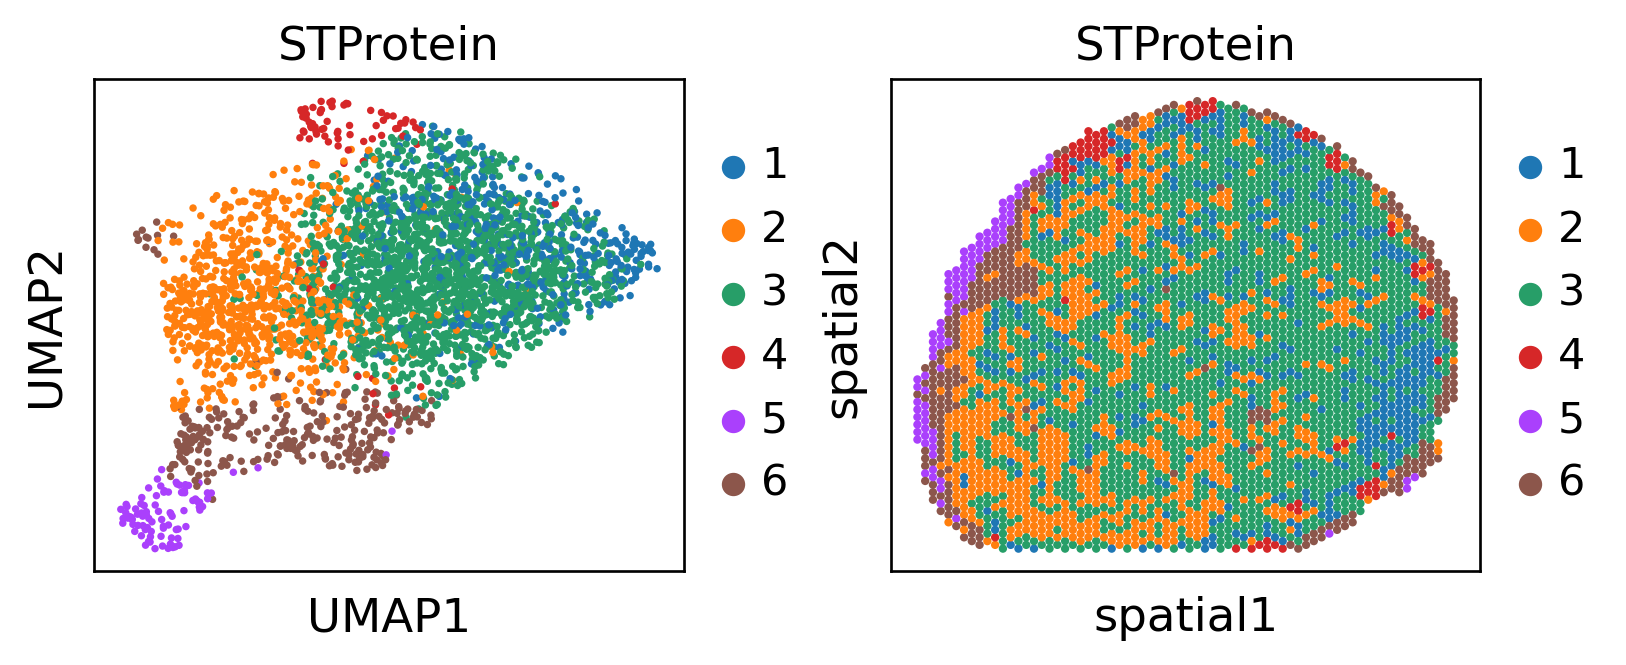

In [ ]:
# visualization
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 2, figsize=(7, 3))
sc.pp.neighbors(prediction, use_rep='embedding', n_neighbors=10)
sc.tl.umap(prediction)

sc.pl.umap(prediction, color='embedding', ax=ax_list[0], title='STProtein', s=20, show=False)
sc.pl.embedding(prediction, basis='spatial', color='embedding', ax=ax_list[1], title='STProtein', s=25, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

In [808]:
# ground_truth = sc.read_h5ad('/data/hulei/ZhaoruiJiang/Data/SpatialGlue/Ground-Truth/' + "adata_all_mouse_spleen_rep2.h5ad")
ground_truth = sc.read_h5ad('/data/hulei/ZhaoruiJiang/Data/SpatialGlue/Ground-Truth/' + "adata_all_human_lymph_node_D1.h5ad")
ground_truth.obs['Pro_label_origi']

AACACTTGGCAAGGAA-1    1
AACAGGATTCATAGTT-1    2
AACAGGTTATTGCACC-1    2
AACAGGTTCACCGAAG-1    1
AACAGTCAGGCTCCGC-1    2
                     ..
TGTTGCGTCCAAGATT-1    1
TGTTGGAACCTTCCGC-1    2
TGTTGGAACGAGGTCA-1    1
TGTTGGATGGACTTCT-1    2
TGTTGGCCAGACCTAC-1    1
Name: Pro_label_origi, Length: 3359, dtype: category
Categories (6, int64): [1, 2, 3, 4, 5, 6]

In [809]:
label = ground_truth.obs['Pro_label_origi']
list = label.tolist()
path_1 = 'GT_list'
with open(path_1, 'w') as f:
    for num in list:
        f.write(f"{num}\n")

In [810]:
label = prediction.obs['mclust']
list = label.tolist()
path_2 = 'Our_list'
with open(path_2, 'w') as f:
    for num in list:
        f.write(f"{num}\n")

In [811]:
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
from sklearn.metrics import v_measure_score, homogeneity_score, completeness_score
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score
from metric import jaccard, Dice, F_measure
from sklearn.metrics import silhouette_score

In [812]:
def read_list_from_file(path):
    list = []
    with open(path, 'r') as f:
        for line in f:
            num = int(line.strip())
            list.append(num)
    return list

In [813]:
GT_list = read_list_from_file(path_1)
Our_list = read_list_from_file(path_2)

In [814]:
Our_Jaccard = jaccard(Our_list, GT_list)
print(f"our         jaccard: {Our_Jaccard*100:.6f}")
Our_F_measure = F_measure(Our_list, GT_list)
print(f"our         F_measure: {Our_F_measure*100:.6f}")
Our_mutual_info = mutual_info_score(GT_list, Our_list)
print(f"our         Mutual Information: {Our_mutual_info*100:.6f}")
Our_nmi = normalized_mutual_info_score(GT_list, Our_list)
print(f"Our         (NMI): {Our_nmi*100:.6f}")
Our_ami = adjusted_mutual_info_score(GT_list, Our_list)
print(f"Our         (AMI): {Our_ami*100:.6f}")
Our_V = v_measure_score(GT_list, Our_list)
print(f"Our         V-measure: {Our_V*100:.6f}")
Our_homogeneity = homogeneity_score(GT_list, Our_list)
Our_completeness = completeness_score(GT_list, Our_list)
print(f"Our         Homogeneity: {Our_homogeneity*100:.6f} Completeness: {Our_completeness*100:.6f}")
Our_ari = adjusted_rand_score(GT_list, Our_list)
print(f"Our         (ARI): {Our_ari*100:.6f}")
Our_fmi = fowlkes_mallows_score(GT_list, Our_list)
print(f"Our         (FMI): {Our_fmi*100:.6f}")

our         jaccard: 35.080495
our         F_measure: 51.940134
our         Mutual Information: 49.089876
Our         (NMI): 36.290922
Our         (AMI): 36.110623
Our         V-measure: 36.290922
Our         Homogeneity: 36.413415 Completeness: 36.169250
Our         (ARI): 29.005991
Our         (FMI): 51.940279
